# Исследование сервиса аренды самокатов GoFast

<div style="border:solid black 2px; padding: 20px">

На данных сервиса аренды самокатов GoFast проведем исследовательский анализ и проверим выдвинутые гипотезы.

**Цель исследования** — проверим четыре гипотезы:
1. Пользователи с подпиской тратят больше времени на поездки чем пользователи без подписки.
2. Расстояние одной поездки в 3130 метров — оптимальное с точки зрения износа самоката. Среднее расстояние, которое проезжают пользователи с подпиской за одну поездку, не превышает 
3130 метров.
3.  Помесячная выручка от пользователей с подпиской по месяцам выше, чем выручка от пользователей без подписки.
4. Техническая команда сервиса обновила сервера, с которыми взаимодействует мобильное приложение. Предполагаем, что количество обращений в техподдержку значимо снизилось.

**Ход исследования**

Данные о поведении пользователей получили из файлов:
* `/datasets/users_go.csv`
* `/datasets/rides_go.csv`
* `/datasets/subscriptions_go.csv`

О качестве данных нам ничего не известно. Поэтому перед проверкой гипотез проведем обзор данных. Так как работаем с тремя файлами, понадобится объединение данных.

Таким образом, исследование пройдёт в семь этапов:
1. [Загрузка и обзор данных](#Загрузка_и_обзор_данных)
2. [Предобработка данных](#Предобработка_данных)
3. [Исследовательский анализ данных](#Исследовательский_анализ_данных)
4. [Объединение данных](#Объединение_данных)
5. [Подсчёт выручки](#Подсчёт_выручки)
6. [Проверка гипотез](#Проверка_гипотез)
7. [Итоги исследования](#Итоги_исследования)

**Описание данных**

**Пользователи — users_go.csv**:
* user_id: уникальный идентификатор пользователя
* name: имя пользователя
* age: возраст
* city: город
* subscription_type: тип подписки (free, ultra)

**Поездки — rides_go.csv**:
* user_id: уникальный идентификатор пользователя
* distance: расстояние, которое пользователь проехал в текущей сессии (в метрах)
* duration: продолжительность сессии (в минутах) — время с того момента, как пользователь нажал кнопку «Начать поездку» до момента, как он нажал кнопку «Завершить поездку»
* date: дата совершения поездки

**Подписки — subscriptions_go.csv**:
* subscription_type: тип подписки
* minute_price: стоимость одной минуты поездки по данной подписке
* start_ride_price: стоимость начала поездки
* subscription_fee: стоимость ежемесячного платежа

</div>

<a id="Загрузка_и_обзор_данных"></a>

## Загрузка и обзор данных

<div style="border:solid black 2px; padding: 20px">

**Шаг 1.** Импортируем библиотеки. Считываем данные из csv-файлов в датафрейм и сохраняем в переменные.

</div>

In [1]:
import pandas as pd
import matplotlib.pyplot as plt 
import numpy as np 
from scipy import stats as st
import math
from random import randint

In [2]:
data_users = pd.read_csv('users_go.csv') # чтение файла с данными пользователях и сохранение в data_users
data_rides = pd.read_csv('rides_go.csv') # чтение файла с данными о поезках и сохранение в data_rides
data_subscriptions = pd.read_csv('subscriptions_go.csv') # чтение файла с подписках о поезках и сохранение в data_subscriptions

<div style="border:solid black 2px; padding: 20px">

**Шаг 2.** Выведем первые 10 строчек датафреймов на экран.

</div>

In [3]:
data_users.head() # получение первых 5 строк таблицы data_users

,user_id,name,age,city,subscription_type
0,1,Кира,22,Тюмень,ultra
1,2,Станислав,31,Омск,ultra
2,3,Алексей,20,Москва,ultra
3,4,Константин,26,Ростов-на-Дону,ultra
4,5,Адель,28,Омск,ultra


In [4]:
data_rides.head(15) # получение первых 15 строк таблицы data_rides

,user_id,distance,duration,date
0,1,4409.919140,25.599769,2021-01-01
1,1,2617.592153,15.816871,2021-01-18
2,1,754.159807,6.232113,2021-04-20
3,1,2694.783254,18.511000,2021-08-11
4,1,4028.687306,26.265803,2021-08-28
5,1,2770.890808,16.650138,2021-10-09
6,1,3039.020292,14.927879,2021-10-19
7,1,2842.118050,23.117468,2021-11-06
8,1,3412.690668,15.238072,2021-11-14
9,1,748.690645,15.041884,2021-11-22


In [5]:
data_subscriptions.head() # получение первых 5 строк таблицы data_subscriptions

,subscription_type,minute_price,start_ride_price,subscription_fee
0,free,8,50,0
1,ultra,6,0,199


<div style="border:solid black 2px; padding: 20px">

**Шаг 3.** Получим общую информацию о таблицах.

</div>

In [6]:
data_users.info() # получение общей информации о данных в таблице data_users

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1565 entries, 0 to 1564
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   user_id            1565 non-null   int64 
 1   name               1565 non-null   object
 2   age                1565 non-null   int64 
 3   city               1565 non-null   object
 4   subscription_type  1565 non-null   object
dtypes: int64(2), object(3)
memory usage: 61.3+ KB


In [7]:
data_rides.info() # получение общей информации о данных в таблице data_rides

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18068 entries, 0 to 18067
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   user_id   18068 non-null  int64  
 1   distance  18068 non-null  float64
 2   duration  18068 non-null  float64
 3   date      18068 non-null  object 
dtypes: float64(2), int64(1), object(1)
memory usage: 564.8+ KB


In [8]:
data_subscriptions.info() # получение общей информации о данных в таблице data_subscriptions

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 4 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   subscription_type  2 non-null      object
 1   minute_price       2 non-null      int64 
 2   start_ride_price   2 non-null      int64 
 3   subscription_fee   2 non-null      int64 
dtypes: int64(3), object(1)
memory usage: 196.0+ bytes


<div style="border:solid black 2px; padding: 20px">

**Шаг 4.** Получим стандартное отклонение и другие характеристики таблицы data_rides.

</div>

In [9]:
data_rides.describe().T # просмотр основных статистических данных

,count,mean,std,min,25%,50%,75%,max
user_id,18068.0,842.869936,434.734317,1.000000,487.000000,889.000000,1213.250000,1534.000000
distance,18068.0,3070.659976,1116.831209,0.855683,2543.226360,3133.609994,3776.222735,7211.007745
duration,18068.0,17.805011,6.091051,0.500000,13.597563,17.678395,21.724800,40.823963


<div style="border:solid green 2px; padding: 20px">

В предобработке данных рассмотреть комментарии ниже:
* В таблицах нет пропусков исходя из данных info.
* Столбец date: Dtype object. Изменить Dtype на datetime.
* Проверить неявные дубликаты в столбце city.
* Так как таблицы необходимо будет объединять, учесть момент дублей.

</div>

<a id='Предобработка_данных'></a>

## Предобработка данных

### Приведем столбец 'date' к типу даты pandas

In [10]:
# меняем тип данных на 'datetime'
data_rides['date'] = pd.to_datetime(data_rides['date'], format='%Y-%m-%d')

In [11]:
data_rides['month'] = data_rides['date'].dt.month # создаем новый столбец и присваиваем месяц

In [12]:
data_rides['year'] = data_rides['date'].dt.year

In [13]:
data_rides['year'].value_counts()

year
2021    18068
Name: count, dtype: int64

In [14]:
data_rides.head() # получение первых 5 строк таблицы data_rides

,user_id,distance,duration,date,month,year
0,1,4409.919140,25.599769,2021-01-01,1,2021
1,1,2617.592153,15.816871,2021-01-18,1,2021
2,1,754.159807,6.232113,2021-04-20,4,2021
3,1,2694.783254,18.511000,2021-08-11,8,2021
4,1,4028.687306,26.265803,2021-08-28,8,2021


<div style="border:solid green 2px; padding: 20px">

Изменили тип данных в столбце 'date' на 'datetime'.

Создали новый столбец 'month'.

</div>

### Обработка пропущенных значений

In [15]:
data_users.isnull().mean() * 100 # проверяем наличие и долю пропусков в data_users

user_id              0.0
name                 0.0
age                  0.0
city                 0.0
subscription_type    0.0
dtype: float64

In [16]:
data_rides.isnull().mean() * 100 # проверяем наличие и долю пропусков в data_rides

user_id     0.0
distance    0.0
duration    0.0
date        0.0
month       0.0
year        0.0
dtype: float64

In [17]:
data_subscriptions.isnull().mean() * 100 # проверяем наличие и долю пропусков в data_subscriptions

subscription_type    0.0
minute_price         0.0
start_ride_price     0.0
subscription_fee     0.0
dtype: float64

<div style="border:solid green 2px; padding: 20px">

Мы убедились, что пропущенных значений в таблицах нет.

</div>

### Обработка дубликатов

<div style="border:solid black 2px; padding: 20px">
    
Проверим явные дубликаты в таблицах.

</div>

In [18]:
data_users.duplicated().sum() # проверка на отсутствие явных дубликатов в data_users

31

In [19]:
data_rides.duplicated().sum() # проверка на отсутствие явных дубликатов в data_rides

0

In [20]:
data_subscriptions.duplicated().sum() # проверка на отсутствие явных дубликатов в data_subscriptions

0

In [21]:
data_users = data_users.drop_duplicates().reset_index(drop=True) # удаление явных дубликатов, создание новых индексов и удаление старых

In [22]:
data_users.duplicated().sum() # проверка на отсутствие явных дубликатов в data_users

0

<div style="border:solid green 2px; padding: 20px">

Удалили явные дубликаты.

</div>

<div style="border:solid black 2px; padding: 20px">
    
Проверим неявные дубликаты в таблицах.

</div>

In [23]:
data_users['city'].sort_values().unique() # просмотр уникальных отсортированных названий городов

array(['Екатеринбург', 'Краснодар', 'Москва', 'Омск', 'Пятигорск',
       'Ростов-на-Дону', 'Сочи', 'Тюмень'], dtype=object)

In [24]:
data_users['city'].value_counts() # количество уникальных совпадений по городам

city
Пятигорск         219
Екатеринбург      204
Ростов-на-Дону    198
Краснодар         193
Сочи              189
Омск              183
Тюмень            180
Москва            168
Name: count, dtype: int64

In [25]:
data_users['age'].value_counts().sort_index(ascending=True) # количество уникальных совпадений по возрасту

age
12      4
13      8
14      9
15     13
16     19
17     26
18     46
19     47
20     71
21     93
22    119
23    129
24    132
25    145
26    131
27    119
28    112
29     68
30     68
31     48
32     41
33     39
34     19
35     15
36      6
37      2
38      3
39      1
43      1
Name: count, dtype: int64

In [26]:
# для удобстава анализа создадим еще один столбец с категориями по возрасту

# функция возвращает категорию по значению от возраста, используя правила:
def type_age(row):
    if row['age'] < 21:
        return 'от 12 до 20 лет'
    elif row['age'] < 31:
        return 'от 21 до 30 лет'
    return 'от 31 до 43 лет'

data_users['age_type'] = data_users.apply(type_age, axis=1)

In [27]:
data_users.groupby('age_type')['age'].value_counts() # проверяем работу функции

age_type         age
от 12 до 20 лет  20      71
                 19      47
                 18      46
                 17      26
                 16      19
                 15      13
                 14       9
                 13       8
                 12       4
от 21 до 30 лет  25     145
                 24     132
                 26     131
                 23     129
                 27     119
                 22     119
                 28     112
                 21      93
                 30      68
                 29      68
от 31 до 43 лет  31      48
                 32      41
                 33      39
                 34      19
                 35      15
                 36       6
                 38       3
                 37       2
                 39       1
                 43       1
Name: count, dtype: int64

<div style="border:solid green 2px; padding: 20px">

Неявных дубликатов нет.
    
Изначально планировали объединить города по количеству пользователей (например, там, где их немного, вывести отдельно), но как мы видим количество пользователей не сильно отличается по городам.

Добавили новый столбец 'age_type' для аналитики по возрасту.

</div>

<a id="Исследовательский_анализ_данных"></a>

## Исследовательский анализ данных

<div style="border:solid black 2px; padding: 20px">
    
Опишем и визуализируем общую информацию о пользователях и поездках.

</div>

### Частота встречаемости городов

In [28]:
data_users['city'].describe() # выводим основные статистические данные по столбцу

count          1534
unique            8
top       Пятигорск
freq            219
Name: city, dtype: object

In [29]:
# сгруппируем данные по столбцу 'city'
# посчитаем количество строк по столбцу 'user_id'
data_users.groupby('city')['user_id'].agg('count').sort_values(ascending=False)\
          .reset_index().rename(columns= {'user_id': 'Количество пользователей', 'city': 'Город'})

,Город,Количество пользователей
0,Пятигорск,219
1,Екатеринбург,204
2,Ростов-на-Дону,198
3,Краснодар,193
4,Сочи,189
5,Омск,183
6,Тюмень,180
7,Москва,168


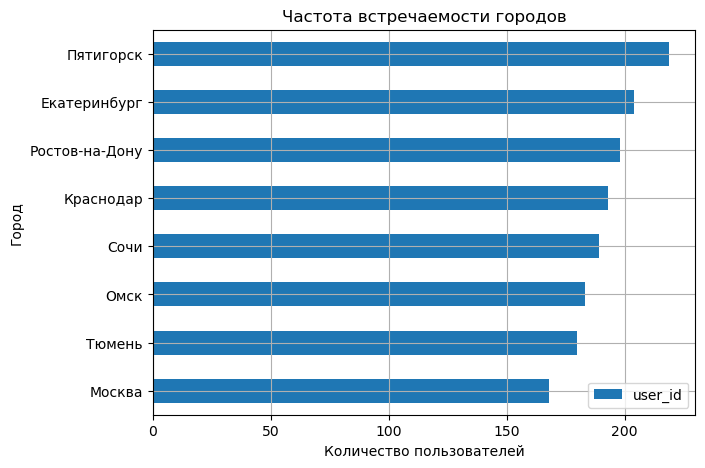

In [30]:
data_users.pivot_table(index='city', values='user_id', aggfunc='count')\
          .sort_values(by='user_id').plot(kind='barh', grid=True, figsize=(7,5), title='Частота встречаемости городов')
plt.xlabel('Количество пользователей')
plt.ylabel('Город')
plt.show()

<div style="border:solid green 2px; padding: 20px">

Частота встречаемости городов:

* В таблице 'Пользователи' мы имеем данные о пользователях из 8 городов.
* В данных Top по частоте встречаемости - Пятигорск.
* Разница по частоте встречаемости между городами небольшая (например, доля количества пользователей в Пятигорске 14% от общего количества пользователей в выгрузке, а в Москве 11%). Соответственно вопрос по укрупнению групп для анализа не рассматриваем.
* Нам передали данные о некоторых пользователях из нескольких городов, но нет информации, эта выборка была сделана по соотношению долей от общего количества пользователей в городах или рандомно, соответственно мы не можем сделать вывод, что в городе Пятигорск услугами сервиса аренды самокатов пользуется больше пользователей чем в городе Москва.

</div>

### Соотношение пользователей с подпиской и без подписки

In [31]:
data_users['subscription_type'].describe() # выводим основные статистические данные по столбцу

count     1534
unique       2
top       free
freq       835
Name: subscription_type, dtype: object

In [32]:
# представим значения Value_counts в процентах (в формате десятичных дробей)
data_users['subscription_type'].value_counts(normalize=True).round(3)

subscription_type
free     0.544
ultra    0.456
Name: proportion, dtype: float64

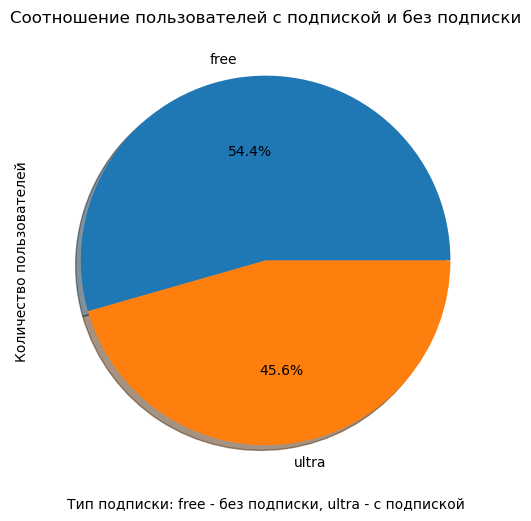

In [33]:
data_users.groupby('subscription_type')['user_id'].count()\
.plot(kind='pie', figsize=(6,6), shadow=True, autopct='%1.1f%%', title='Соотношение пользователей с подпиской и без подписки')
plt.ylabel('Количество пользователей')
plt.xlabel('Тип подписки: free - без подписки, ultra - с подпиской')
plt.show()

In [34]:
# сгруппируем данные по столбцу 'city'
# посчитаем количество строк по столбцу 'subscription_type'
data_users.groupby(['city', 'subscription_type'])['user_id'].count()\
          .reset_index().rename(columns= {'user_id': 'Количество пользователей по типу подписки'})

,city,subscription_type,Количество пользователей по типу подписки
0,Екатеринбург,free,112
1,Екатеринбург,ultra,92
2,Краснодар,free,112
3,Краснодар,ultra,81
4,Москва,free,84
5,Москва,ultra,84
6,Омск,free,92
7,Омск,ultra,91
8,Пятигорск,free,125
9,Пятигорск,ultra,94


<div style="border:solid green 2px; padding: 20px">

**Соотношение пользователей с подпиской и без подписки:**

Доля пользователей без подписки составила 54%, с подпиской 46%. Разница 8%.

В данной выборке количество пользователей без подписки больше, чем количество пользователей с подпиской.

Разница небольшая, возможно если бы соотношение количества пользователей по городам было другое, то мы могли бы получить значение ближе к 50%. Например, была бы больше выборка по Москве (где доли с подпиской и без подписки равны), или добавлен город Санкт-Петербург, пользователи в этих городах знакомы ближе с подписками и вероятно более активно ими пользуются.

</div>

### Возраст пользователей

In [35]:
data_users['age'].describe() # выводим основные статистические данные по столбцу

count    1534.000000
mean       24.903520
std         4.572367
min        12.000000
25%        22.000000
50%        25.000000
75%        28.000000
max        43.000000
Name: age, dtype: float64

In [36]:
# считаем количество строк по условию
print('Количество пользователей младше 15 лет:', len(data_users[data_users['age'] <= 15]))

Количество пользователей младше 15 лет: 34


In [37]:
# считаем количество строк по условию
print('Количество пользователей старше 35 лет:', len(data_users[data_users['age'] >= 35]))

Количество пользователей старше 35 лет: 28


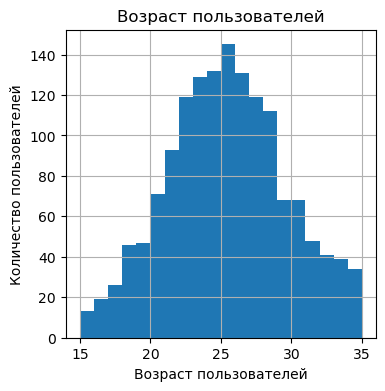

In [38]:
# строим гистограмму
data_users['age'].hist(bins=20, range=(15, 35), figsize=(4,4))
plt.ylabel('Количество пользователей')
plt.xlabel('Возраст пользователей')
plt.title('Возраст пользователей')
plt.show()

In [39]:
# представим значения Value_counts в процентах (в формате десятичных дробей)
data_users['age_type'].value_counts(normalize=True).round(2)

age_type
от 21 до 30 лет    0.73
от 12 до 20 лет    0.16
от 31 до 43 лет    0.11
Name: proportion, dtype: float64

<div style="border:solid green 2px; padding: 20px">

**Возраст пользователей:**

В выборке пользователи от 12 до 43 лет. У большинства пользователей возраст от 23 до 28 лет. Медиана 25 лет.

Сделали также категоризацию по возрасту, самая большая доля у пользователей от 21 до 30 лет (73%).

Типичный пользователь:
* трудоустроен (старше 23 лет)
* возраст до 28 лет заставляет задуматься о семейном статусе и наличии детей

</div>

### Расстояние, которое пользователь преодолел за одну поездку

In [40]:
data_rides['distance'].describe() # выводим основные статистические данные по столбцу

count    18068.000000
mean      3070.659976
std       1116.831209
min          0.855683
25%       2543.226360
50%       3133.609994
75%       3776.222735
max       7211.007745
Name: distance, dtype: float64

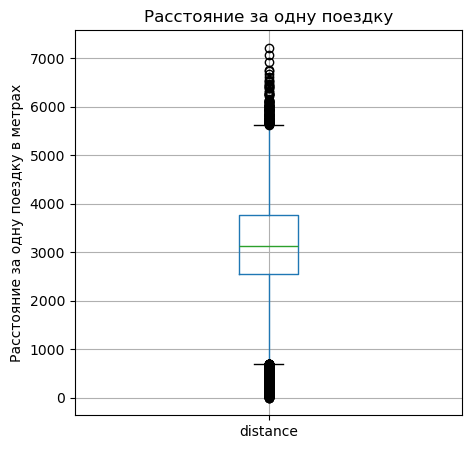

In [41]:
# строим диаграмму размаха
data_rides.boxplot('distance', figsize=(5, 5))
plt.ylabel('Расстояние за одну поездку в метрах')
plt.title('Расстояние за одну поездку')
plt.show()

In [42]:
# считаем количество строк по условию
print('Расстояние меньше 400 метров:', len(data_rides[data_rides['distance'] < 400]))

Расстояние меньше 400 метров: 424


In [43]:
# считаем количество строк по условию
print('Расстояние больше 5700 метров:', len(data_rides[data_rides['distance'] > 5700]))

Расстояние больше 5700 метров: 100


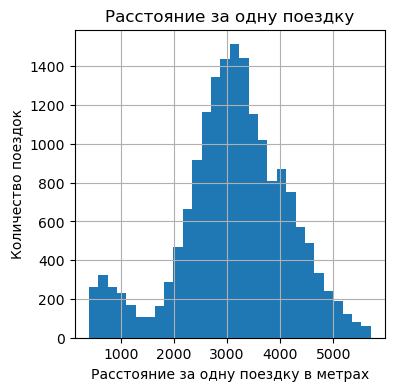

In [44]:
data_rides['distance'].hist(bins=30, range=(400, 5700), figsize=(4,4)) # строим гистограмму
plt.ylabel('Количество поездок')
plt.xlabel('Расстояние за одну поездку в метрах')
plt.title('Расстояние за одну поездку')
plt.show()

<div style="border:solid green 2px; padding: 20px">

**Расстояние, которое пользователь преодолел за одну поездку:**
* Медиана 3133 м., среднее 3070 м. Это же значение является пиковым на гистограмме.
* У большинства пользователей расстояние поездки от 2500 до 3500 м.
* Обычный, со здоровым организмом человек, считается, может пройти 1 километр за 12 минут, так как средняя скорость человека 5 км/час.
Соответственно пользователь на самокате в среднем преодолевает расстояние, на которое мог потратить 37 минут пешком.
* Малый пик в районе 500-700 метров говорит о том, что есть потребность и в преодолении небольших расстояний.

</div>

### Продолжительность поездок

In [45]:
data_rides['duration'].describe() # выводим основные статистические данные по столбцу

count    18068.000000
mean        17.805011
std          6.091051
min          0.500000
25%         13.597563
50%         17.678395
75%         21.724800
max         40.823963
Name: duration, dtype: float64

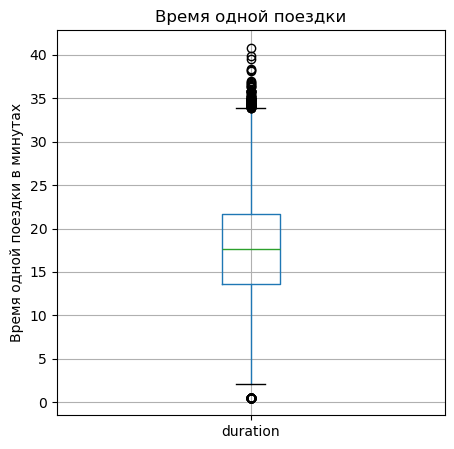

In [46]:
# строим диаграмму размаха
data_rides.boxplot('duration', figsize=(5, 5))
plt.ylabel('Время одной поездки в минутах')
plt.title('Время одной поездки')
plt.show()

In [47]:
# считаем количество строк по условию
print('Продолжительность поездки меньше 3 минут:', len(data_rides[data_rides['duration'] < 3]))

Продолжительность поездки меньше 3 минут: 128


In [48]:
# считаем количество строк по условию
print('Продолжительность поездки больше 33 минут:', len(data_rides[data_rides['duration'] > 33]))

Продолжительность поездки больше 33 минут: 146


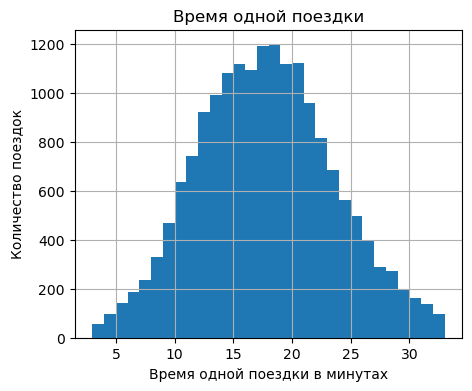

In [49]:
data_rides['duration'].hist(bins=30, range=(3, 33), figsize=(5,4)) # строим гистограмму
plt.ylabel('Количество поездок')
plt.xlabel('Время одной поездки в минутах')
plt.title('Время одной поездки')
plt.show()

<div style="border:solid green 2px; padding: 20px">

**Продолжительность одной поездки (в минутах)** — время с того момента, как пользователь нажал кнопку «Начать поездку» до момента, как он нажал кнопку «Завершить поездку».

Медиана 17.7 минут, среднее 17.8 минут. На гистограмме отсутствуют заметные выбросы.

У большинства пользователей время одной поездки от 13 до 22 минут.

Поездки до 3х минут и больше 33 минут практически отсутствуют (доля каждого меньше 1% от общего числа поездок).

</div>

### Исследование по аномалиям в продолжительности сессии

In [50]:
print('Расстояние в метрах (медиана):', data_rides['distance'].median(),\
      '. Время в минутах (медиана):', data_rides['duration'].median())
meters_per_minute = data_rides['distance'].median() / data_rides['duration'].median()
print('Расстояние в метрах за минуту:', meters_per_minute)

Расстояние в метрах (медиана): 3133.6099936787664 . Время в минутах (медиана): 17.678394530393803
Расстояние в метрах за минуту: 177.25648040557462


In [51]:
# группируем данные по коротким отрезкам времени и пройденному расстоянию
duration_min = data_rides.query('duration < 4').groupby(data_rides['duration'].round(1))['distance'].agg(['count', 'mean', 'median']).round()
duration_min['calculation_time'] = (duration_min['median'] / meters_per_minute).round(2)
print(duration_min)

          count    mean  median  calculation_time
duration                                         
0.5          95  5113.0  5053.0             28.51
2.0           1    11.0    11.0              0.06
2.1           1    24.0    24.0              0.14
2.2           4    76.0    75.0              0.42
2.3           6   110.0   105.0              0.59
2.4           2   127.0   127.0              0.72
2.5           5   190.0   215.0              1.21
2.7           2   268.0   268.0              1.51
2.8           3   333.0   295.0              1.66
2.9           7   361.0   393.0              2.22
3.0           5   295.0   407.0              2.30
3.1           5   345.0   392.0              2.21
3.2           5   167.0    87.0              0.49
3.3           3   423.0   588.0              3.32
3.4           5   415.0   613.0              3.46
3.5           5   336.0   236.0              1.33
3.6           9   512.0   560.0              3.16
3.7           4   376.0   290.0              1.64


In [52]:
user_id_1min = data_rides.query('duration < 2').groupby([data_rides['duration'].round(1), 'user_id', 'date'])['distance'].agg(['count', 'median']).round()
user_id_1min.head(20)

count  median
duration user_id date                     
0.5      701     2021-08-31      1  4196.0
         704     2021-10-14      1  4831.0
         712     2021-03-04      1  4684.0
         713     2021-02-25      1  5216.0
         718     2021-02-11      1  5197.0
         724     2021-12-16      1  6226.0
         726     2021-03-01      1  4452.0
         735     2021-04-13      1  4407.0
         745     2021-08-17      1  5286.0
         760     2021-08-29      1  4881.0
         766     2021-12-22      1  4539.0
         772     2021-05-22      1  4719.0
         774     2021-05-27      1  5488.0
         780     2021-11-23      1  6113.0
         784     2021-06-03      1  5203.0
         792     2021-11-06      1  5353.0
         795     2021-09-09      1  6262.0
         800     2021-07-19      1  5052.0
         804     2021-05-10      1  5548.0
         836     2021-01-12      1  4959.0

<div style="border:solid green 2px; padding: 20px">

Сравнили продолжительность сессий (выбрав только короткие до 4 минут) и расстояние поездок.

Вычислили значение 'медианное расстояние в метрах за минуту' и разделили это значение на 'медианное расстояние в метрах' сгруппированной таблицы.

Особенно не стыкуются данные первой строки, где время одной поездки в исходнике 1/2 минуты, а расчетное реальное время, за которое можно поехать данное расстояние, получилось 28.5 минут. Не получилось найти очевидную взаимосвязь между аномальными поездками (пользователи и даты разные).

Хоть эти данные и не бьются с реальностью, но удалять их не будем, так как это повлияет на выручку.

</div>

### Вывод по исследовательскому анализу данных

<div style="border:solid blue 2px; padding: 20px">

***Изучив общую информацию о пользователях и поезках, можно сделать следующие выводы:***

**Частота встречаемости городов.**

* В таблице 'Пользователи' мы имеем данные о пользователях из 8 городов.
* В данных Top по частоте встречаемости - Пятигорск, но в целом разница по количеству пользователей небольшая между городами (доля количества пользователей в Пятигорске 14% от общего количества пользователей в выгрузке, а в Москве 11%).
Нам передали данные о некоторых пользователях из нескольких городов, но нет информации, эта выборка была сделана по соотношению долей от общего количества пользователей в городах или рандомно, соответственно мы не может сделать вывод, что в городе Пятигорск услугами сервиса аренды самокатов пользуется больше пользователей чем в городе Москва.

**Соотношение пользователей с подпиской и без подписки.**
* Доля пользователей без подписки составила 54%, с подпиской 46%. Разница 8%.
* В данной выборке количество пользователей без подписки больше, чем количество пользователей с подпиской.
* Разница долей небольшая, возможно если бы соотношение количества пользователей по городам было другое, то мы могли бы получить значение ближе к 50%. Например, была бы больше выборка по Москве (где доли с подпиской и без подписки равны), или добавлен город Санкт-Петербург, пользователи в этих городах знакомы ближе с подписками и вероятно более активно ими пользуются.

**Возраст пользователей.**
* В выборке пользователи от 12 до 43 лет. У большинства пользователей возраст от 23 до 28 лет. Медиана 25 лет.
* Сделали также категоризацию по возрасту, самая большая доля по возрасту у пользователей от 21 до 30 лет (73%).
* Пользователь: трудоустроен (старше 23 лет) и возраст до 28 лет заставляет задуматься о семейном статусе и наличии детей.

**Расстояние, которое пользователь преодолел за одну поездку (в метрах).**
* Медиана 3133 м., среднее 3070 м. Это же значение является пиковым на гистограмме.
* У большинства пользователей расстояние поездки от 2500 до 3500 м.
* Обычный, со здоровым организмом человек, считается, может пройти 1 километр за 12 минут, так как средняя скорость человека 5 км/час. Соответственно пользователь на самокате в среднем преодолевает расстояние, на которое мог потратить 37 минут пешком.
* Малый пик в районе 500-700 метров говорит о том, что есть потребность и в преодолении небольших расстояний.

**Продолжительность поездок (в минутах).**
* Медиана 17.7 минут, среднее 17.8 минут. На гистограмме отсутствуют заметные выбросы.
* У большинства пользователей время одной поездки от 13 до 22 минут.
* Поездки до 3х минут и больше 33 минут практически отсутствуют (доля каждого меньше 1% от общего числа поездок).

</div>

<a id="Объединение_данных"></a>

## Объединение данных

### Объединение данных

<div style="border:solid black 2px; padding: 20px">
    
Объединим данные о пользователях, поездках и подписках в один датафрейм. Для этого воспользуемся методом merge().

</div>

In [53]:
# каждое значение из столбца округляется с помощью «потолка»
data_rides['duration'] = np.ceil(data_rides['duration'])

In [54]:
# используем метод merge() и соединим датафреймы
data_combine = (data_users.merge(data_rides, on='user_id').merge(data_subscriptions, on='subscription_type'))

In [55]:
print('Размер таблицы data_combine:', data_combine.shape) # размер таблицы

Размер таблицы data_combine: (18068, 14)


In [56]:
print('Размер таблицы data_rides:', data_rides.shape) # размер таблицы

Размер таблицы data_rides: (18068, 6)


In [57]:
data_combine['user_id'].nunique() # количество уникальных значений в столбце

1534

In [58]:
data_users['user_id'].nunique() # количество уникальных значений в столбце

1534

In [59]:
data_combine.isna().sum() # количество пропущенных значений

user_id              0
name                 0
age                  0
city                 0
subscription_type    0
age_type             0
distance             0
duration             0
date                 0
month                0
year                 0
minute_price         0
start_ride_price     0
subscription_fee     0
dtype: int64

<div style="border:solid green 2px; padding: 20px">

Объединили 3 датафрейма в один.

Проверили количество строк в новом датафрейме относительно исходных таблиц.

Проверили количество пропущенных значений.


</div>

### Датафреймы по типу подписки

<div style="border:solid black 2px; padding: 20px">
    
Создадим ещё два датафрейма из датафрейма, созданного на этапе 4.1:
* c данными о пользователях без подписки 'data_free'
* с данными о пользователях с подпиской 'data_ultra'

</div>

In [60]:
# фильтруем строки в соответствии с указанным логическим выражением
data_free = data_combine.query('subscription_type == "free"')

In [61]:
# фильтруем строки в соответствии с указанным логическим выражением
data_ultra = data_combine.query('subscription_type == "ultra"')

In [62]:
len(data_combine) - (len(data_free) + len(data_ultra)) # проверяем разницу строк после фильтрации

0

In [63]:
data_free.head(2)

,user_id,name,age,city,subscription_type,age_type,distance,duration,date,month,year,minute_price,start_ride_price,subscription_fee
6500,700,Айдар,22,Омск,free,от 21 до 30 лет,2515.690719,15.0,2021-01-02,1,2021,8,50,0
6501,700,Айдар,22,Омск,free,от 21 до 30 лет,846.932642,17.0,2021-02-01,2,2021,8,50,0


In [64]:
data_ultra.head(2)

,user_id,name,age,city,subscription_type,age_type,distance,duration,date,month,year,minute_price,start_ride_price,subscription_fee
0,1,Кира,22,Тюмень,ultra,от 21 до 30 лет,4409.919140,26.0,2021-01-01,1,2021,6,0,199
1,1,Кира,22,Тюмень,ultra,от 21 до 30 лет,2617.592153,16.0,2021-01-18,1,2021,6,0,199


### Визуализация данных по типу подписки

<div style="border:solid black 2px; padding: 20px">
    
Визуализируем информацию о расстоянии поездки и типу подписки.

</div>

In [65]:
data_free['distance'].describe() # выводим основные статистические данные по столбцу

count    11568.000000
mean      3045.495282
std       1246.173806
min          0.855683
25%       2366.562689
50%       3114.648465
75%       3905.697894
max       7211.007745
Name: distance, dtype: float64

In [66]:
data_ultra['distance'].describe() # выводим основные статистические данные по столбцу

count    6500.000000
mean     3115.445388
std       836.895330
min       244.210438
25%      2785.444017
50%      3148.637229
75%      3560.574425
max      5699.769662
Name: distance, dtype: float64

In [67]:
# отношение data_free['distance'] к data_ultra['distance']
(data_free['distance'].describe() - data_ultra['distance'].describe()) / 100

count    50.680000
mean     -0.699501
std       4.092785
min      -2.433548
25%      -4.188813
50%      -0.339888
75%       3.451235
max      15.112381
Name: distance, dtype: float64

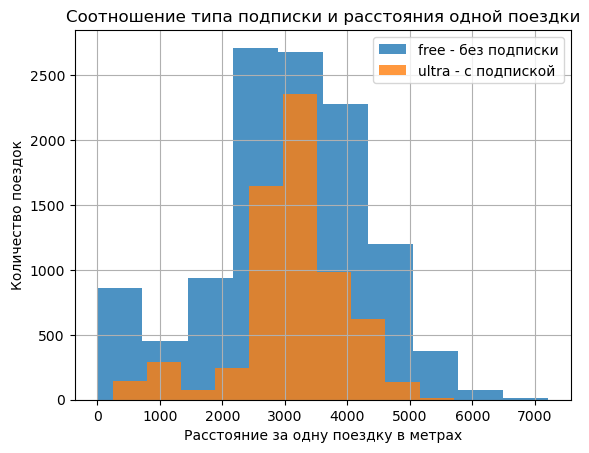

In [68]:
# строим гистограмму для двух таблиц
data1 = data_free['distance']
data2 = data_ultra['distance']

plt.hist(data1, alpha=0.8, label='free - без подписки')
plt.hist(data2, alpha=0.8, label='ultra - с подпиской')
plt.grid(True)
plt.ylabel('Количество поездок')
plt.xlabel('Расстояние за одну поездку в метрах')
plt.title('Соотношение типа подписки и расстояния одной поездки')
plt.legend(loc='upper right')
plt.show()

<div style="border:solid green 2px; padding: 20px">

Соотношение типа подписки и расстояния, которое пользователь проезжает за одну поездку:
* Средняя и медиана по длине поездок у разных типов подписки практически равны (в среднем 3100 м.).
* Существенная разница в количестве поездок: у пользователей без подписки их в 2 раза больше, чем у пользователей с подпиской.
* У пользователей без подписки диапазон расстояния одной поездки шире (от 1 до 7211 метров), а у пользователей с подпиской от 244 до 5699 метров.
* У пользователей без подписки малый пик в промежутке от 1 до 600 метров. Возможно это не длительная запланированная поездка, а знакомство с самокатом и проверка удобства транспорта для конкретного пользователя.

</div>

<div style="border:solid black 2px; padding: 20px">
    
Визуализируем информацию о времени поездки и типу подписки.

</div>

In [69]:
data_free['duration'].describe() # выводим основные статистические данные по столбцу

count    11568.000000
mean        17.890992
std          6.330250
min          1.000000
25%         13.000000
50%         18.000000
75%         22.000000
max         35.000000
Name: duration, dtype: float64

In [70]:
data_ultra['duration'].describe() # выводим основные статистические данные по столбцу

count    6500.000000
mean       19.037692
std         5.577439
min         4.000000
25%        15.000000
50%        19.000000
75%        22.000000
max        41.000000
Name: duration, dtype: float64

In [71]:
# отношение data_free['distance'] к data_ultra['distance']
(data_free['duration'].describe() - data_ultra['duration'].describe()) / 100

count    50.680000
mean     -0.011467
std       0.007528
min      -0.030000
25%      -0.020000
50%      -0.010000
75%       0.000000
max      -0.060000
Name: duration, dtype: float64

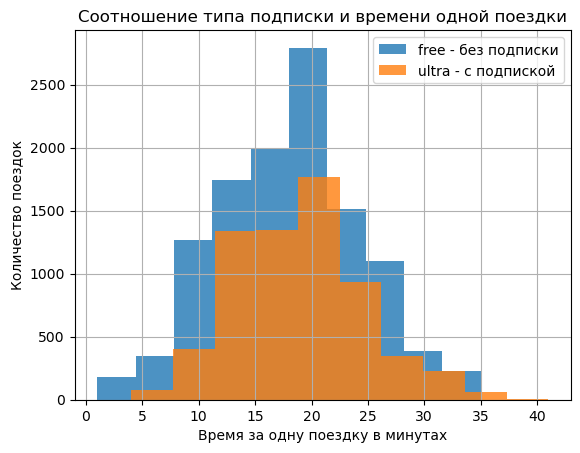

In [72]:
# строим гистограмму для двух таблиц
data3 = data_free['duration']
data4 = data_ultra['duration']

plt.hist(data3, alpha=0.8, label='free - без подписки')
plt.hist(data4, alpha=0.8, label='ultra - с подпиской')
plt.grid(True)
plt.ylabel('Количество поездок')
plt.xlabel('Время за одну поездку в минутах')
plt.title('Соотношение типа подписки и времени одной поездки')
plt.legend(loc='upper right')
plt.show()

In [73]:
# медианные значения
print('Без подписки. Расстояние в метрах (медиана):', data_free['distance'].median(),\
      '. Время в минутах(медиана):', data_free['duration'].median())
print('Без подписки. Расстояние в метрах за минуту:', data_free['distance'].median() / data_free['duration'].median())
print('С подпиской. Расстояние  в метрах (медиана):', data_ultra['distance'].median(),\
      '. Время в минутах(медиана):', data_ultra['duration'].median())
print('С подпиской. Расстояние в метрах за минуту:', data_ultra['distance'].median() / data_ultra['duration'].median())      

Без подписки. Расстояние в метрах (медиана): 3114.648464847295 . Время в минутах(медиана): 18.0
Без подписки. Расстояние в метрах за минуту: 173.03602582484973
С подпиской. Расстояние  в метрах (медиана): 3148.6372291760854 . Время в минутах(медиана): 19.0
С подпиской. Расстояние в метрах за минуту: 165.71774890400448


<div style="border:solid green 2px; padding: 20px">

Соотношение типа подписки и времени, за которое пользователь проезжает одну поездку:
* Среднее время одной поездки у пользователей с подпиской на 1 минуту дольше, чем у пользователей без подписки (19 к 17.9).
* Существенная разница в количестве поездок: у пользователей без подписки их в 2 раза больше, чем у пользователей с подпиской.
* У пользователей с подпиской время поездки дольше (от 4 до 41 минут), а у пользователей с подпиской от 1 до 35 минут.
* По медианным значениям скорость у пользователей без подписки выше (Без подписки: 173 метра в минуту, С подпиской: 165.7 метра в минуту).
  
</div>

<div style="border:solid blue 2px; padding: 20px">

**Вывод**

Мы увидели, что есть разница по ряду параметров между пользователями с подпиской и без подписки:
* У пользователей без подписки количество поездок в 2 раза больше, чем у пользователей с подпиской.
* У пользователей без подписки диапазон расстояния одной поездки шире (от 1 до 7211 метров), а у пользователей с подпиской от 244 до 5699 метров.
* У пользователей с подпиской время поездки дольше (от 4 до 41 минут), а у пользователей с подпиской от 1 до 35 минут.
* Среднее время одной поездки у пользователей с подпиской на 1 минуту дольше, чем у пользователей без подписки.
* По медианным значениям скорость у пользователей без подписки выше (Без подписки: 173 метра в минуту, С подпиской: 165.7 метра в минуту).
* У пользователей без подписки малый пик в промежутке от 1 до 600 метров. Возможно это не длительная запланированная поездка, а знакомство с самокатом и проверка удобства транспорта для конкретного пользователя.
 
</div>

<a id="Подсчёт_выручки"></a>

## Подсчёт выручки

### Создание нового датафрейма с агрегированными данными

<div style="border:solid black 2px; padding: 20px">

Создадим датафрейм с агрегированными данными о поездках на основе датафрейма 'data_combine' и найдем:
* суммарное расстояние для каждого пользователя за каждый месяц
* количество поездок для каждого пользователя за каждый месяц
* суммарное время для каждого пользователя за каждый месяц

</div>

In [74]:
data_combine.head() # выводим первый 5 строк и выбираем нужные столбцы для нового датафрейма

,user_id,name,age,city,subscription_type,age_type,distance,duration,date,month,year,minute_price,start_ride_price,subscription_fee
0,1,Кира,22,Тюмень,ultra,от 21 до 30 лет,4409.919140,26.0,2021-01-01,1,2021,6,0,199
1,1,Кира,22,Тюмень,ultra,от 21 до 30 лет,2617.592153,16.0,2021-01-18,1,2021,6,0,199
2,1,Кира,22,Тюмень,ultra,от 21 до 30 лет,754.159807,7.0,2021-04-20,4,2021,6,0,199
3,1,Кира,22,Тюмень,ultra,от 21 до 30 лет,2694.783254,19.0,2021-08-11,8,2021,6,0,199
4,1,Кира,22,Тюмень,ultra,от 21 до 30 лет,4028.687306,27.0,2021-08-28,8,2021,6,0,199


In [75]:
# создаем новый датафрейм
data_combine_agg = data_combine.pivot_table(index=['user_id', 'month', 'subscription_type'], values=['distance', 'duration', 'minute_price', 'start_ride_price', 'subscription_fee'],
                   aggfunc={'user_id': 'count', 'distance': 'sum', 'duration': 'sum', 'minute_price': 'sum', 'start_ride_price': 'sum', 'subscription_fee': 'sum'})\
                  .rename(columns= {'user_id': 'Количество поездок', 'distance': 'Расстояние', 'duration': 'Время', 'minute_price': 'Стоимость минуты', 'start_ride_price': 'Стоимость начала поездки', 'subscription_fee': 'Ежемесячный платеж'})

In [76]:
# меняем значение столбца для будущих расчетов
data_combine_agg['Стоимость минуты'] = data_combine_agg['Стоимость минуты'] / data_combine_agg['Количество поездок']
data_combine_agg['Стоимость начала поездки'] = data_combine_agg['Стоимость начала поездки'] / data_combine_agg['Количество поездок']
data_combine_agg['Ежемесячный платеж'] = data_combine_agg['Ежемесячный платеж'] / data_combine_agg['Количество поездок']

In [77]:
data_combine_agg.head() # выводим первый 5 строк нового датафрейма

Расстояние  Время  Стоимость минуты  \
user_id month subscription_type                                         
1       1     ultra              7027.511294   42.0               6.0   
        4     ultra               754.159807    7.0               6.0   
        8     ultra              6723.470560   46.0               6.0   
        10    ultra              5809.911100   32.0               6.0   
        11    ultra              7003.499363   56.0               6.0   

                                 Стоимость начала поездки  Ежемесячный платеж  \
user_id month subscription_type                                                 
1       1     ultra                                   0.0               199.0   
        4     ultra                                   0.0               199.0   
        8     ultra                                   0.0               199.0   
        10    ultra                                   0.0               199.0   
        11    ultra                                   0.0               199.0   

                                 Количество поездок  
user_id month subscription_type                      
1       1     ultra                               2  
        4     ultra                               1  
        8     ultra                               2  
        10    ultra                               2  
        11    ultra                               3

### Подсчёт выручки

<div style="border:solid black 2px; padding: 20px">

Помесячная выручка:
* стоимость старта поездки*количество поездок
* +стоимость одной минуты поездки*общая продолжительность всех поездок в минутах
* +стоимость подписки

</div>

In [78]:
data_combine_agg['Выручка'] = (data_combine_agg['Стоимость начала поездки'] * data_combine_agg['Количество поездок']) + (data_combine_agg['Стоимость минуты'] * data_combine_agg['Время']) + data_combine_agg['Ежемесячный платеж']

In [79]:
data_combine_agg.head() # выводим первый 5 строк нового датафрейма

Расстояние  Время  Стоимость минуты  \
user_id month subscription_type                                         
1       1     ultra              7027.511294   42.0               6.0   
        4     ultra               754.159807    7.0               6.0   
        8     ultra              6723.470560   46.0               6.0   
        10    ultra              5809.911100   32.0               6.0   
        11    ultra              7003.499363   56.0               6.0   

                                 Стоимость начала поездки  Ежемесячный платеж  \
user_id month subscription_type                                                 
1       1     ultra                                   0.0               199.0   
        4     ultra                                   0.0               199.0   
        8     ultra                                   0.0               199.0   
        10    ultra                                   0.0               199.0   
        11    ultra                                   0.0               199.0   

                                 Количество поездок  Выручка  
user_id month subscription_type                               
1       1     ultra                               2    451.0  
        4     ultra                               1    241.0  
        8     ultra                               2    475.0  
        10    ultra                               2    391.0  
        11    ultra                               3    535.0

<div style="border:solid green 2px; padding: 20px">

Создали датафрейм для проверки гипотез.

</div>

<a id="Проверка_гипотез"></a>

## Проверка гипотез

<div style="border:solid black 2px; padding: 20px">

Продакт-менеджеры сервиса хотят увеличить количество пользователей с подпиской.
Для этого они будут проводить различные акции.

Для запуска активностей надо проверить гипотезы ниже.

</div>

### Гипотеза. Пользователи с подпиской тратят больше времени на поездки

<div style="border:solid black 2px; padding: 20px">

Гипотеза. Пользователи с подпиской тратят больше времени на поездки, чем пользователи без подписки.

В пункте 3.2 мы выяснили, что доля пользователей без подписки составила 54%, с подпиской 46%. 

Соответственно будем сравнивать по средним значениям.

Гипотеза:
* H₀: Среднее время поездки пользователей с подпиской равно среднему времени поездки пользователей без подписки.
* H1: Среднее время поездки пользователей с подпиской больше среднего времени поездки пользователей без подписки.

Применим двухвыборочный t-тест для независимых выборок.

Ответим на вопросы:
* Тратят ли пользователи с подпиской больше времени на поездки?
* Если да, то пользователи с подпиской могут быть «выгоднее» для компании?

</div>

In [80]:
# пользователи с подпиской
sample_time1 = data_ultra['duration']

# пользователи без подписки
sample_time2 = data_free['duration']

print(f'Среднее время пользователя с подпиской: {np.mean(sample_time1)}')
print(f'Среднее время пользователя без подписки: {np.mean(sample_time2)}')

alpha = 0.05 # задаем уровень стат. значимости

results1 = st.ttest_ind(sample_time1, sample_time2, alternative='greater') # проведем стат. тест 

# выведем на экран получившееся p-значение
print('p-значение:', results1.pvalue)

if results1.pvalue < alpha: # сравним p-значение с alpha
    print('Отвергаем нулевую гипотезу')
else:
    print('Не получилось отвергнуть нулевую гипотезу')

Среднее время пользователя с подпиской: 19.037692307692307
Среднее время пользователя без подписки: 17.890992392807746
p-значение: 2.4959453720736625e-34
Отвергаем нулевую гипотезу


<div style="border:solid green 2px; padding: 20px">

Есть основания полагать, что пользователи с подпиской тратят больше времени на поездки, чем пользователи без подписки.

Только по параметру время нельзя однозначно сказать, что пользователи с подпиской могут быть «выгоднее» для компании, надо в первую очередь смотреть на выручку.

</div>

### Гипотеза. Пользователи с подпиской за поездку проезжают не больше 3130 метров

<div style="border:solid black 2px; padding: 20px">

Расстояние одной поездки в 3130 метров — оптимальное с точки зрения износа самокат.

Гипотеза. Пользователи с подпиской за поездку проезжают не больше 3130 метров.
* H₀: Среднее расстояние за поездку пользователей с подпиской равно 3130 метров.
* Н1: Среднее расстояние за поездку пользователей с подпиской больше 3130 метров..


Одновыборочный t-тест.

</div>

In [81]:
distance_ultra = data_ultra['distance']
# пользователи с подпиской

prev_distance_ultra = 3130

print(f'Среднее расстояние с подпиской: {np.mean(distance_ultra)}')

alpha = 0.05 # уровень статистической значимости

results2 = st.ttest_1samp(distance_ultra, prev_distance_ultra, alternative='greater')

print('p-значение:', results2.pvalue)

if (results2.pvalue < alpha):
    print('Отвергаем нулевую гипотезу')
else:
    print('Не отвергаем нулевую гипотезу') 

Среднее расстояние с подпиской: 3115.4453880370247
p-значение: 0.9195368847849785
Не отвергаем нулевую гипотезу


<div style="border:solid green 2px; padding: 20px">

Не отвергаем нулевую гипотезу.

Есть основания говорить, что пользователи с подпиской не проезжают больше 3130 м.

Это является оптимальным с точки зрения износа.

</div>

### Гипотеза. Помесячная выручка от пользователей с подпиской по месяцам выше, чем выручка от пользователей без подписки

<div style="border:solid black 2px; padding: 20px">

Гипотеза. Помесячная выручка от пользователей с подпиской по месяцам выше, чем выручка от пользователей без подписки.

В пункте 3.2 мы выяснили, что доля пользователей без подписки составила 54%, с подпиской 46%. 

Соответственно мы не можем сравнивать общую выручку, и для сравнения возьмем среднюю выручку по типу подписки.

Гипотеза:
* H₀: Средняя помесячная выручка пользователей с подпиской равна средней помесячной выручке пользователей без подписки.
* Н1: Средняя помесячная выручка пользователей с подпиской больше средней помесячной выручки пользователей без подписки.

Применим двухвыборочный t-тест для независимых выборок.

</div>

In [82]:
# пользователи с подпиской
sample_value1 =  data_combine_agg[data_combine_agg['Ежемесячный платеж'] > 0]['Выручка']

# пользователи без подписки
sample_value2 = data_combine_agg[data_combine_agg['Ежемесячный платеж'] == 0]['Выручка']

print(f'Средняя выручка пользователей с подпиской: {np.mean(sample_value1)}')
print(f'Средняя выручка пользователей без подписки: {np.mean(sample_value2)}')

alpha = 0.05 # задаем уровень стат. значимости

results3 = st.ttest_ind(sample_value1, sample_value2, alternative='greater') # проведем стат. тест 

# выведем на экран получившееся p-значение
print('p-значение:', results3.pvalue)

if results3.pvalue < alpha: # сравним p-значение с alpha
    print('Отвергаем нулевую гипотезу')
else:
    print('Не получилось отвергнуть нулевую гипотезу')

Средняя выручка пользователей с подпиской: 362.7921906022502
Средняя выручка пользователей без подписки: 328.6413651073845
p-значение: 1.8850394384715216e-31
Отвергаем нулевую гипотезу


<div style="border:solid black 2px; padding: 20px">

Проверим результат с помощью графика.

</div>

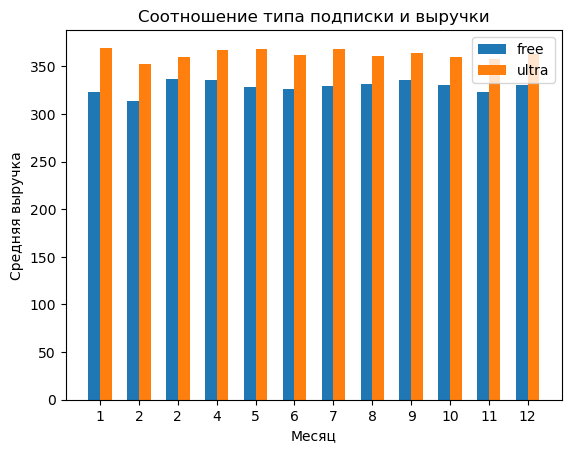

In [83]:
labels = [1,2,2,4,5,6,7,8,9,10,11,12]

free = data_combine_agg[data_combine_agg['Ежемесячный платеж'] == 0].groupby('month')['Выручка'].mean()
ultra = data_combine_agg[data_combine_agg['Ежемесячный платеж'] > 0].groupby('month')['Выручка'].mean()
x = np.arange(len(labels)) 

width = 0.3
fig, ax = plt.subplots()
rect1 = ax.bar(x - width/2, free, width, label='free')
rect2 = ax.bar(x + width/2, ultra, width, label='ultra')

ax.set_ylabel('Средняя выручка')
ax.set_xlabel('Месяц')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.set_title('Соотношение типа подписки и выручки')
ax.legend()

plt.show()

<div style="border:solid green 2px; padding: 20px">

Есть основания говорить, что пользователи с подпиской генерируют сервису большую выручку, чем пользователи без подписки.

Если отвечать на вопрос из пункта 6.1 "пользователи с подпиской могут быть «выгоднее» для компании?", то да, пользователи с подпиской вероятно могут быть «выгоднее» для компании.

</div>

### Гипотеза. Количество обращений в техподдержку значимо снизилось после обновления сервера

<div style="border:solid black 2px; padding: 20px">

Рассмотрим ситуацию: техническая команда сервиса обновила сервера, с которыми взаимодействует мобильное приложение.

Она надеется, что из-за этого количество обращений в техподдержку значимо снизилось.

Некоторый файл содержит для каждого пользователя данные о количестве обращений до обновления и после него.

Какой тест нам понадобится бы для проверки этой гипотезы?

</div>

<div style="border:solid green 2px; padding: 20px">

В данном случае будем анализировать одну генеральную совокупность, с которой произошли некоторые изменения.

Предполагаю, что выборки в этом случае будут зависимыми, так как в условии указано, что "файл содержит для каждого пользователя данные о количестве обращений до обновления и после него".

Важно убедиться, что обе выборки одинаковые по размеру, т.е. порядок объектов, для которых сделаны измерения, в обоих массивах тоже одинаковый.

Сформулируем гипотезы:
* H₀: Среднее количество обращений после обновления равно среднему количеству обращений до обновления.
* Н1: Среднее количество обращений после обновления меньше среднего количества обращений до обновления.

Применим метод scipy.stats.ttest_rel() для проверки гипотезы о равенстве среднего генеральной совокупности для зависимых выборок.

Напишем код в качестве примера, где сделаем генерацию случайных чисел.



</div>

In [84]:
after = [randint(1, 30) for i in range(10)]

before = [randint(1, 30) for i in range(10)]

print(f'Среднее after: {np.mean(after)}')
print(f'Среднее before: {np.mean(before)}')

alpha = 0.05 # уровень статистической значимости

results = st.ttest_rel(after, before, alternative='less')

print('p-значение:', results.pvalue)

if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не получилось отвергнуть нулевую гипотезу')

Среднее after: 19.1
Среднее before: 12.5
p-значение: 0.9176132953467435
Не получилось отвергнуть нулевую гипотезу


<div style="border:solid green 2px; padding: 20px">

Получились значения ниже при первом запуске.
* Среднее after: 13.3
* Среднее before: 16.7
* p-значение: 0.2138672633535681
* Не получилось отвергнуть нулевую гипотезу


Есть основания говорить, что количество обращений уменьшилось после обновления сервера.

</div>

<div style="border:solid blue 2px; padding: 20px">

**Выводы по результатам проверки гипотез:**

* Есть основания считать, что пользователи с подпиской тратят больше времени на поездки, чем пользователи без подписки.
* Есть основания говорить, что пользователи с подпиской не проезжают больше 3130 м.
* Можно сделать вывод, что пользователи с подпиской тратят в сервисе больше денег, чем пользователи без подписки. Таким образом, пользователи с подпиской могут быть «выгоднее» для компании.
* В пункте 6.4 применили метод scipy.stats.ttest_rel() для проверки гипотезы о равенстве среднего генеральной совокупности для зависимых выборок. Важно убедиться, что обе выборки одинаковые по размеру, т.е. порядок объектов, для которых сделаны измерения, в обоих массивах тоже одинаковый.

</div>

<a id="Итоги_исследования"></a>

## Итоги исследования

<div style="border:solid blue 2px; padding: 20px">

Для улучшений работы качества и повышения прибыли сервиса аренды самокатов GoFast провели исследование на основании предоставленных данных и проверили ряд гипотез.

**Обзор пользователя сервиса аренды самокатов GoFast:**
* **Локация.** Пользователи из 8 городов (Пятигорск, Екатеринбург, Ростов-на-Дону, Краснодар, Сочи, Омск, Тюмень, Москва). Нам передали данные о некоторых пользователях из нескольких городов, но нет информации, эта выборка была сделана по соотношению долей от общего количества пользователей в городах или рандомно, соответственно мы не может сделать вывод, что в городе Пятигорск услугами сервиса аренды самокатов пользуется больше пользователей чем в городе Москва (исходя из полученных данных: доля количества пользователей в Пятигорске 14% от общего количества пользователей в выгрузке, а в Москве 11%).
* **Наличие подписки.** Доля пользователей без подписки составила 54%, с подпиской 46%. Разница долей небольшая, возможно если бы соотношение количества пользователей по городам было другое, то мы могли бы получить значение ближе к 50%. Например, была бы больше выборка по Москве (где доли с подпиской и без подписки равны), или добавлен город Санкт-Петербург, пользователи в этих городах знакомы ближе с подписками и вероятно более активно ими пользуются.
* **Возраст пользователей.** В выборке пользователи от 12 до 43 лет. У большинства пользователей возраст от 23 до 28 лет. Медиана 25 лет. Пользователи в возрасте от 21 до 30 лет занимают долю 73%.
* **Расстояние, которое пользователь преодолел за одну поездку (в метрах).** У большинства пользователей расстояние поездки от 2500 до 3500 м. Медиана 3133 м., среднее 3070 м. Это же значение является пиковым на гистограмме. Малый пик в районе 500-700 метров говорит о том, что есть потребность и в преодолении небольших расстояний.
* **Продолжительность поездок (в минутах).** У большинства пользователей время одной поездки от 13 до 22 минут. Медиана 17.7 минут, среднее 17.8 минут. На гистограмме отсутствуют заметные выбросы. Поездки до 3х минут и больше 33 минут практически отсутствуют (доля каждого меньше 1% от общего числа поездок).
    
    
**Мы увидели, что есть разница по ряду параметров между пользователями с подпиской и без подписки:**
* У пользователей без подписки количество поездок в 2 раза больше, чем у пользователей с подпиской.
* У пользователей без подписки диапазон расстояния одной поездки шире (от 1 до 7211 метров), а у пользователей с подпиской от 244 до 5699 метров.
* У пользователей с подпиской время поездки дольше (от 4 до 41 минут), а у пользователей с подпиской от 1 до 35 минут.
* Среднее время одной поездки у пользователей с подпиской на 1 минуту дольше, чем у пользователей без подписки.
* По медианным значениям скорость у пользователей без подписки выше (Без подписки: 173 метра в минуту, С подпиской: 165.7 метра в минуту).
* У пользователей без подписки малый пик в промежутке от 1 до 600 метров. Возможно это не длительная запланированная поездка, а знакомство с самокатом и проверка удобства транспорта для конкретного пользователя.
 


**Проверили гипотезы и установили, что все гипотезы подтвердились.**

* Гипотеза 1. Пользователи с подпиской тратят больше времени на поездки.
* Гипотеза 2. Пользователи с подпиской за поездку проезжают не больше 3130 метров.
* Гипотеза 3. Помесячная выручка от пользователей с подпиской по месяцам выше, чем выручка от пользователей без подписки.
* Гипотеза 4. Количество обращений в техподдержку значимо снизилось после обновления сервера. Какой тест вам понадобился бы для проверки этой гипотезы? Для проверки данной гипотезы применили метод scipy.stats.ttest_rel() о равенстве среднего генеральной совокупности для зависимых выборок.

Исходя из комментариев выше, можно сделать вывод, что пользователи с подпиской генерируют большую часть выручки для сервиса.

Соответственно сервис должен стимулировать путем различных активностей пользователей без подписки приобретать подписку.

Обращаем внимание, что по пункту 4.3 скорость у пользователей без подписки выше. Мы можем полагать, что пользователи без подписки чаще создают риски попадания в аварийные ситуации, которые влекут за собой ремонт самокатов. Целесообразно провести дополнительные исследования пользователей на аварийность.

</div>